In [1]:
"""
Set up environment
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from mpl_toolkits.mplot3d import Axes3D
import graphviz
%matplotlib inline

# annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Load data
"""
titanic = pd.read_csv("titanic.csv")

In [3]:
"""
Clean and transform data
"""
# examine titanic data
titanic.head()

# check assumptions about using decision tree
# survived is a binary label
# pclass is a multinomal categorical variable, should binarize
# name is not helpful, maybe titles but that can be captured elsewhere
# sex is a binary categrical variable in this dataset
# Siblings/Spouses Abord is a binary variable
# Parents/Children aborad is a binary variable
# Fare is a continuous variable, should set threshholds
# convert series to arrays
titanic["FirstClass"] = (titanic["Pclass"] == 1).astype(int)
titanic["SecondClass"] = (titanic["Pclass"] == 2).astype(int)
titanic["ThirdClass"] = (titanic["Pclass"] == 3).astype(int)
titanic["Woman"] = (titanic["Sex"] == 'female').astype(int)
titanic["Old"] = (titanic["Age"] > 55).astype(int)
titanic["Young"] = (titanic["Age"] < 18).astype(int)
titanic["SameAgeFamily"] = (titanic["Siblings/Spouses Aboard"] > 0).astype(int)
titanic["DifferentAgeFamily"] = (titanic["Parents/Children Aboard"] > 0).astype(int)

titanic_X = titanic.drop(["Survived", "Pclass", "Name", "Sex", "Age",
                          "Fare", "Siblings/Spouses Aboard", "Parents/Children Aboard"], axis=1).values
feature_names = titanic.columns.drop(["Survived", "Pclass", "Name", "Sex", "Age", "Fare", "Siblings/Spouses Aboard", "Parents/Children Aboard"])
titanic_y = titanic["Survived"].copy().values
label_name = "Survived"

In [4]:
"""
Split data
"""
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.2, random_state=42)

In [5]:
"""
Train model
"""
# let's do two types of examinations, first let's do the greedy information gain tree
# initialize model
dct = tree.DecisionTreeClassifier()

# train model
dct = dct.fit(X_train, y_train)

# second, let's do a random forest model
rf = RandomForestClassifier(n_estimators=100)  # 0.22 default

# train model
rf = rf.fit(X_train, y_train)

In [6]:
"""
Make predictions with model
"""
tree_predictions = dct.predict(X_test) 
forest_predictions = rf.predict(X_test)


In [7]:
"""
Evaluate model
"""
# evaluate test subset
print("-"*60)
print("Decision Tree Evaluation")
print("-"*60)
print(f"Number of mislabeled points out of a total {len(tree_predictions)}: {(y_test != tree_predictions).sum()}")
print(f"Accuracy: {1 - (y_test != tree_predictions).sum() / len(tree_predictions)}")
print(f"Mean squared error: {mean_squared_error(y_test, tree_predictions)}")
print(f"Variance score: {r2_score(y_test, tree_predictions)}")

print("-"*60)
print("Random Forest Evaluation")
print("-"*60)
print(f"Number of mislabeled points out of a total {len(forest_predictions)}: {(y_test != forest_predictions).sum()}")
print(f"Accuracy: {1 - (y_test != forest_predictions).sum() / len(forest_predictions)}")
print(f"Mean squared error: {mean_squared_error(y_test, forest_predictions)}")
print(f"Variance score: {r2_score(y_test, forest_predictions)}")

------------------------------------------------------------
Decision Tree Evaluation
------------------------------------------------------------
Number of mislabeled points out of a total 178: 40
Accuracy: 0.7752808988764045
Mean squared error: 0.2247191011235955
Variance score: 0.04262471426650538
------------------------------------------------------------
Random Forest Evaluation
------------------------------------------------------------
Number of mislabeled points out of a total 178: 41
Accuracy: 0.7696629213483146
Mean squared error: 0.2303370786516854
Variance score: 0.018690332123168063


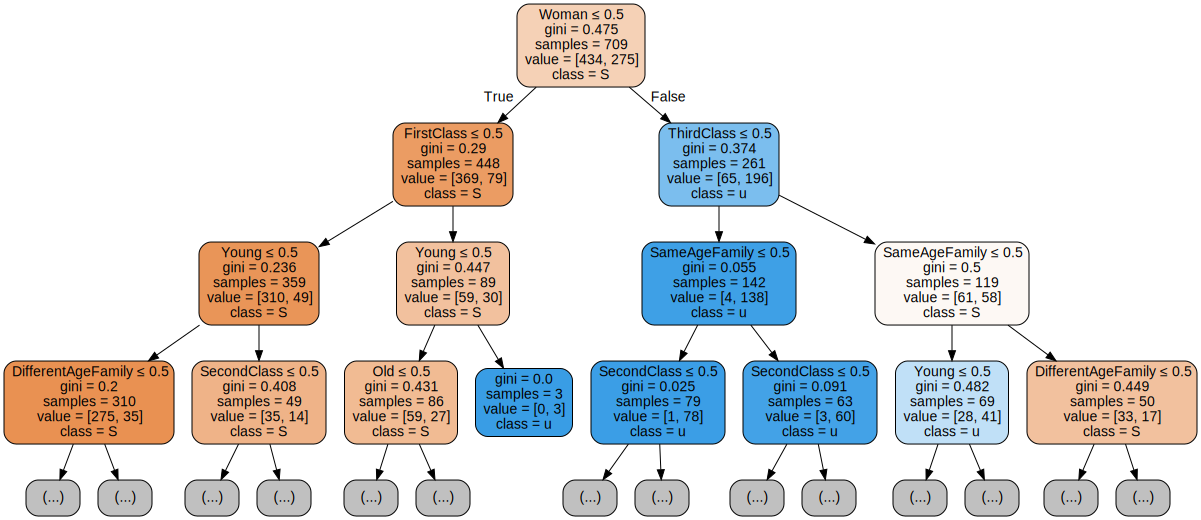

In [8]:
"""
Model Visualization
"""
tree_plot = tree.export_graphviz(dct, out_file=None, max_depth=3, feature_names=feature_names, 
                                 class_names=label_name, filled=True, 
                                 rounded=True, special_characters=True)
graphviz.Source(tree_plot)

In [9]:
"""
Feature engineering
"""
print("-"*60)
print("Decision Tree Feature Importances")
print("-"*60)
for name, importance in zip(feature_names, dct.feature_importances_):
    print(f"{name}: {importance}\n")
    
print("-"*60)
print("Random Forest Feature Importances")
print("-"*60)
for name, importance in zip(feature_names, rf.feature_importances_):
    print(f"{name}: {importance}\n")

------------------------------------------------------------
Decision Tree Feature Importances
------------------------------------------------------------
FirstClass: 0.03328487171483662

SecondClass: 0.0181625312076758

ThirdClass: 0.17662339298895052

Woman: 0.6316266004889366

Old: 0.013293533723144357

Young: 0.04579117373824555

SameAgeFamily: 0.043885291004608556

DifferentAgeFamily: 0.03733260513360199

------------------------------------------------------------
Random Forest Feature Importances
------------------------------------------------------------
FirstClass: 0.09475982359872713

SecondClass: 0.03338149374121758

ThirdClass: 0.12473948885363892

Woman: 0.573586304499489

Old: 0.0184273737676258

Young: 0.05262467932633948

SameAgeFamily: 0.049833572983537994

DifferentAgeFamily: 0.05264726322942405



In [10]:
"""
Performance variation
"""
def performance():
    # split data
    X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.2, random_state=42)
    
    # initialize model
    dct = tree.DecisionTreeClassifier(max_features=4)

    # train model
    dct = dct.fit(X_train, y_train)

    # second, let's do a random forest model
    rf = RandomForestClassifier(n_estimators=100)  # 0.22 default

    # train model
    rf = rf.fit(X_train, y_train)
    
    # make predictions
    tree_predictions = dct.predict(X_test) 
    forest_predictions = rf.predict(X_test)
    
    # capture error
    tree_error = mean_squared_error(y_test, tree_predictions)
    forest_error = mean_squared_error(y_test, forest_predictions)
    
    # capture feature importance
    tree_fi = dct.feature_importances_
    forest_fi = rf.feature_importances_
    
    return (tree_error, forest_error), (tree_fi, forest_fi)

performances = [performance() for i in range(1000)]
errors, feature_importances = [p[0] for p in performances], [p[1] for p in performances]

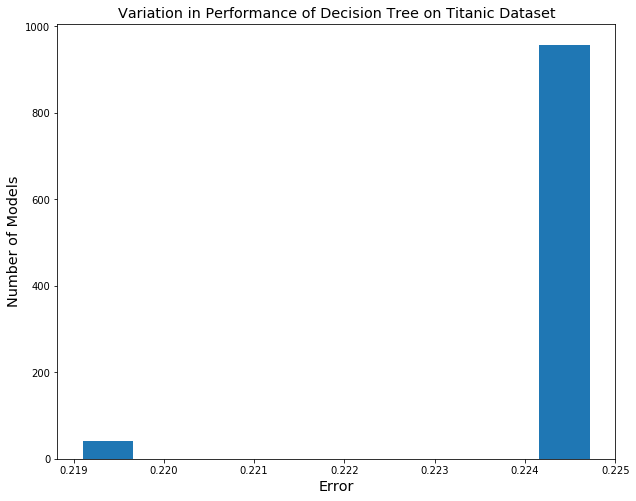

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
bins = ax.hist([e[0] for e in errors])
ax.set_xlabel('Error', size='x-large')
ax.set_ylabel('Number of Models', size='x-large')
ax.set_title('Variation in Performance of Decision Tree on Titanic Dataset', size='x-large')
fig.show()

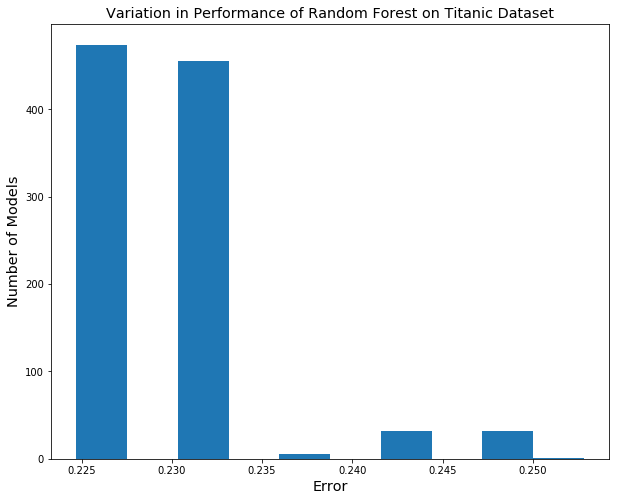

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
bins = ax.hist([e[1] for e in errors])
ax.set_xlabel('Error', size='x-large')
ax.set_ylabel('Number of Models', size='x-large')
ax.set_title('Variation in Performance of Random Forest on Titanic Dataset', size='x-large')
fig.show()

In [13]:
tree_importances = [fi[0] for fi in feature_importances]
avg_tree_importances = np.array(tree_importances).mean(axis=0)

forest_importances = [fi[1] for fi in feature_importances]
avg_forest_importances = np.array(tree_importances).mean(axis=0)

print("-"*60)
print("Decision Tree Feature Importances")
print("-"*60)
for name, importance in zip(feature_names, avg_tree_importances):
    print(f"{name}: {importance}\n")
    
print("-"*60)
print("Random Forest Feature Importances")
print("-"*60)
for name, importance in zip(feature_names, avg_forest_importances):
    print(f"{name}: {importance}\n")

------------------------------------------------------------
Decision Tree Feature Importances
------------------------------------------------------------
FirstClass: 0.061144559476762846

SecondClass: 0.029894858749254908

ThirdClass: 0.15323202038840988

Woman: 0.6102104296940268

Old: 0.014012837754983947

Young: 0.050199707245066796

SameAgeFamily: 0.04221533260140384

DifferentAgeFamily: 0.03909025409009077

------------------------------------------------------------
Random Forest Feature Importances
------------------------------------------------------------
FirstClass: 0.061144559476762846

SecondClass: 0.029894858749254908

ThirdClass: 0.15323202038840988

Woman: 0.6102104296940268

Old: 0.014012837754983947

Young: 0.050199707245066796

SameAgeFamily: 0.04221533260140384

DifferentAgeFamily: 0.03909025409009077

